<a href="https://colab.research.google.com/github/abs-git/GNN/blob/main/Node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

# Samples of benchmark dataset

In [ ]:
import torch
from torch_geometric.datasets import TUDataset, Planetoid, WikiCS, ShapeNet
from torch_geometric.transforms import NormalizeFeatures

enzymes_dataset = TUDataset('ENZYMES', name = 'ENZYMES')
cora_dataset = Planetoid('Cora', name = 'Cora')
shapenet_dataset = ShapeNet('ShapeNet', categories=['Airplane'])

wikics_dataset = WikiCS('wikics', pre_transform= NormalizeFeatures())


In [14]:
# ENZYMES 
# ENZYMES 데이터는 그래프 수준의 학습에 사용되는 데이터 셋이다.

print(len(enzymes_dataset))                 # 그래프의 수 (train, val, test 로 분리하여 사용한다.)
print(enzymes_dataset.num_classes)          # 개별 그래프 내의 클래스 수
print(enzymes_dataset.num_node_features)    # 개별 그래프 내의 노드 특징 수
print()

data = enzymes_dataset[0]

print(data)
print(data.is_undirected())                 # 방향성 그래프 or 비방향성 그래프
print()

print(data.edge_index.shape)                # 그래프의 연결성 : [2, num_edges]
print(data.x.shape)                         # 노드 특징 행렬 : [num_nodes, num_node_features]
print(data.edge_attr)                       # 엣지 특징 행렬 : [num_edges, num_edge_features] (그래프 수준의 데이터 셋이라 존재하지 않는다.)
print(data.y)                               # target 값 : 그래프 레벨 (num_nodes, *), 노드 레벨 (1, *)


600
6
3

Data(edge_index=[2, 168], x=[37, 3], y=[1])
True

torch.Size([2, 168])
torch.Size([37, 3])
None
tensor([5])


In [17]:
# Cora
# Cora dataset은 노드 수준의 학습을 위해 사용된다.

print(len(cora_dataset))                 # 그래프의 수 
print(cora_dataset.num_classes)          # 그래프 내의 클래스 수
print(cora_dataset.num_node_features)    # 그래프 내의 노드 특징 수
print()

data = cora_dataset[0]

print(data)
print(data.is_undirected())                 # 방향성 그래프 or 비방향성 그래프
print()

print(data.edge_index.shape)                # 그래프의 연결성 : [2, num_edges]
print(data.x.shape)                         # 노드 특징 행렬 : [num_nodes, num_node_features]
print(data.edge_attr)                       # 엣지 특징 행렬 : 존재할 경우 [num_edges, num_edge_features] 
print(data.y)                               # target 값 : 그래프 레벨 (num_nodes, *), 노드 레벨 (1, *)
print(data.y.shape)

1
7
1433

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
True

torch.Size([2, 10556])
torch.Size([2708, 1433])
None
tensor([3, 4, 4,  ..., 3, 3, 3])
torch.Size([2708])


In [24]:
# ShapeNet

print(len(shapenet_dataset))                 # 그래프의 수
print(shapenet_dataset.num_classes)          # 개별 그래프 내의 클래스 수
print(shapenet_dataset.num_node_features)    # 개별 그래프 내의 노드 특징 수  (3차원 point)
print()

data = shapenet_dataset[0]

print(data)                                 # edge_index가 존재하지 않는 것은 노드간 연결이 없다는 뜻이다.
print()

print(data.x.shape)                         # 노드 특징 행렬 : [num_nodes, num_node_features]
print(data.edge_attr)                       # 엣지 특징 행렬 : [num_edges, num_edge_features]
print(data.y)                               # target 값 : 그래프 레벨 (num_nodes, *), 노드 레벨 (1, *)


2349
50
3

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

torch.Size([2518, 3])
None
tensor([0, 0, 3,  ..., 3, 1, 1])


# Using WikiCS Dataset

> https://arxiv.org/pdf/2007.02901.pdf



In [4]:
# WikiCS
# Using wikics dataset

print('Number of Graph : {}'.format(len(wikics_dataset)))                            # 그래프의 수 
print('Number of Class per graph : {}'.format(wikics_dataset.num_classes))           # 그래프 내의 클래스 수
print('Number of feature per each node : {}'.format(wikics_dataset.num_node_features))    # 그래프 내의 노드 특징 수
print()

data = wikics_dataset[0]

print(data)
print('Number of nodes : {}'.format(data.num_nodes))
print('Number of edges : {}'.format(data.num_edges))
print()

print('Is it undiectred graph? : {}'.format(data.is_undirected()))                 # 방향성 그래프 or 비방향성 그래프

print(data.edge_index.shape)                # 그래프의 연결성 : [2, num_edges]
print(data.x.shape)                         # 노드 특징 행렬 : [num_nodes, num_node_features]
print(data.edge_attr)                       # 엣지 특징 행렬 : 존재할 경우 [num_edges, num_edge_features] 
print(data.y)                               # target 값 : 그래프 레벨 (num_nodes, *), 노드 레벨 (1, *)
print(data.y.shape)

Number of Graph : 1
Number of Class per graph : 10
Number of feature per node : 300

Data(x=[11701, 300], edge_index=[2, 431726], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20])
Number of nodes : 11701
Number of edges : 431726

Is it undiectred graph? : True
torch.Size([2, 431726])
torch.Size([11701, 300])
None
tensor([7, 2, 2,  ..., 2, 5, 7])
torch.Size([11701])


In [110]:
# Create GCN model

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, Linear


class GCN(nn.Module):
  def __init__(self, hidden_channels, nFeatures, nClasses, dropout_rate):
    super(GCN, self).__init__()
    
    self.conv1 = GCNConv(nFeatures, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, nClasses)

    self.drop_rate = dropout_rate

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, self.drop_rate)

    x = self.conv2(x, edge_index)

    return F.softmax(x, dim = 1)


class GAT(nn.Module):
  def __init__(self, hidden_channels, nFeatures, nClasses, dropout_rate, attention_heads = 4):
    super().__init__()

    self.conv1 = GATConv(nFeatures, hidden_channels, heads = attention_heads)
    self.conv2 = GATConv(hidden_channels * attention_heads, nClasses, heads = 1)
    self.out = Linear(hidden_channels, nClasses)

    self.drop_rate = dropout_rate

  def forward(self, x, edge_index):

    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, self.drop_rate)

    x = self.conv2(x, edge_index)

    return F.softmax(x, dim = 1)



In [105]:
# Learning utils

import numpy as np
from sklearn.metrics import roc_auc_score
import time
from collections import defaultdict


def trainer(data, model, optimizer, criterion, i_spilts):
  X = data.x
  edge_index = data.edge_index  
  target = data.y

  model.train()
  optimizer.zero_grad()

  outputs = model(X, edge_index)                    # Use all data as input, because all nodes have node features
  
  loss = criterion(outputs[data['train_mask'][:,i_spilts]],   
                   target[data['train_mask'][:,i_spilts]])    # Only use nodes with labels available for loss calculation
  loss.backward()
  optimizer.step()

  return loss


def tester(data, model, index, nClasses):
  X = data.x
  edge_index = data.edge_index
  target = data.y
  
  model.eval()

  outputs = model(X, edge_index)[index]

  # calculate AUC
  y_true = target.cpu().detach().numpy()[index]
  y_mat = np.zeros(shape = (y_true.shape[0], nClasses))

  for i in range(y_true.shape[0]):
    y_mat[i, y_true[i]] = 1
  
  auc = roc_auc_score(y_mat, outputs.cpu().detach().numpy())
  
  # calculate Accuracy
  pred = outputs.argmax(dim = 1)
  correct = int((pred == target[index]).sum())

  accuracy = correct / pred.shape[0]

  scores = [auc, accuracy]

  return scores


def experiment(data, model, optimizer, criterion, nClasses, EPOCHS, i_splits):

  losses = []
  scores = defaultdict(list)

  for epoch in range(1, EPOCHS):

    loss = trainer(data, GCN_model, GCN_optimizer, GCN_criterion, i_splits)
    
    train_score = tester(data, GCN_model, data['train_mask'][:,i_splits], nClasses)
    val_score = tester(data, GCN_model, data['val_mask'][:,i_splits], nClasses)
    test_score = tester(data, GCN_model, data['test_mask'], nClasses)

    losses.append(loss.item())

    scores['train_auc'].append(train_score[0])
    scores['val_auc'].append(val_score[0])
    scores['test_auc'].append(test_score[0])

    scores['train_accuracy'].append(train_score[1])
    scores['val_accuracy'].append(val_score[1])
    scores['test_accuracy'].append(test_score[1])

    if epoch % 10 == 0 :
      print('epoch : {}, train loss : {}'.format(epoch, loss))


  return losses, scores



In [81]:
# Create a GCN model

nFeatures = wikics_dataset.num_features
nClasses = wikics_dataset.num_classes

GCN_model = GCN(hidden_channels = 200, nFeatures = nFeatures, nClasses = nClasses, dropout_rate = 0.3)

GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr = 0.001)
GCN_criterion = torch.nn.CrossEntropyLoss()

GCN_model

GCN(
  (conv1): GCNConv(300, 200)
  (conv2): GCNConv(200, 10)
)

In [ ]:
# Train

EPOCHS = 100
i_splits = 4

GCN_losses, GCN_scores = experiment(data, GCN_model, GCN_optimizer, GCN_criterion, nClasses, EPOCHS, i_splits)


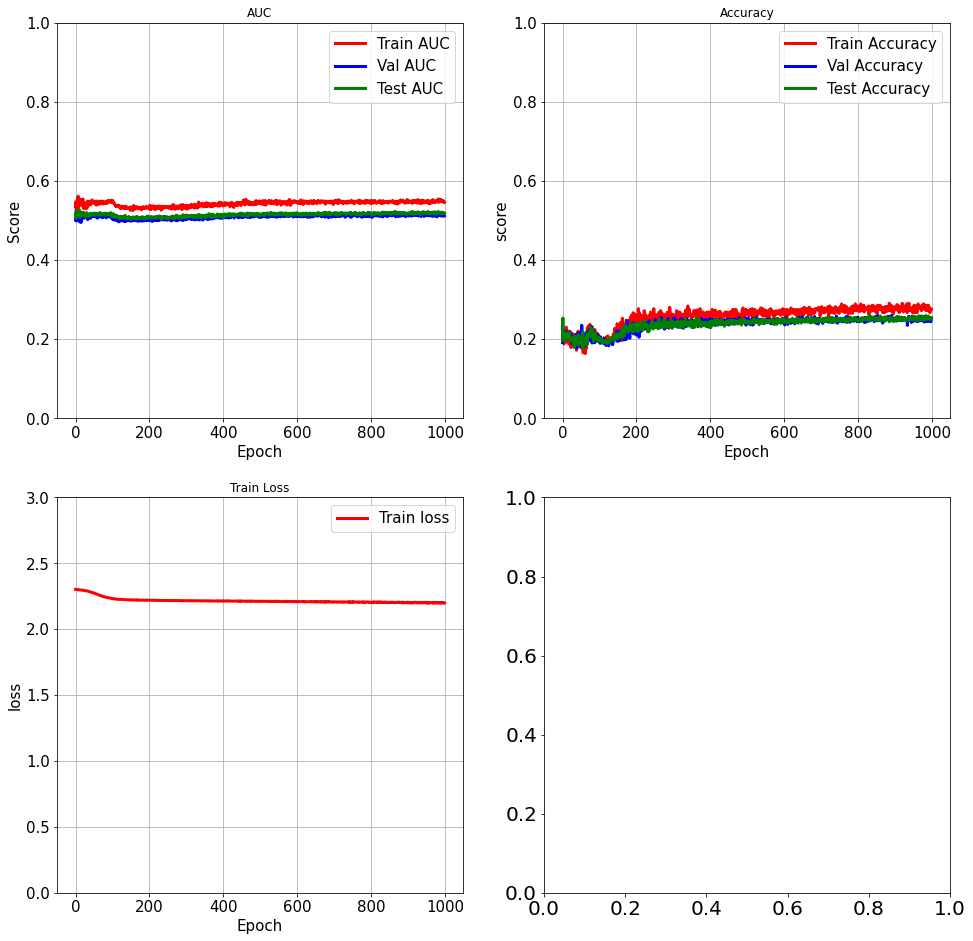

In [16]:
# visualize

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize = (16,16))

# AUC
axes[0][0].plot(GCN_scores['train_auc'], c = 'r', linestyle = 'solid', linewidth = 3)
axes[0][0].plot(GCN_scores['val_auc'], c = 'b', linestyle = 'solid', linewidth = 3)
axes[0][0].plot(GCN_scores['test_auc'], c = 'g', linestyle = 'solid', linewidth = 3)

axes[0][0].set_ylim(0,1)

axes[0][0].set_title("AUC")
axes[0][0].set_xlabel('Epoch', fontsize = 15)
axes[0][0].set_ylabel('Score', fontsize = 15)

axes[0][0].tick_params(labelsize = 15)
axes[0][0].grid()

axes[0][0].legend(['Train AUC', 'Val AUC', 'Test AUC'], fontsize = 15)


# Accuracy
axes[0][1].plot(GCN_scores['train_accuracy'], c = 'r', linestyle = 'solid', linewidth = 3)
axes[0][1].plot(GCN_scores['val_accuracy'], c = 'b', linestyle = 'solid', linewidth = 3)
axes[0][1].plot(GCN_scores['test_accuracy'], c = 'g', linestyle = 'solid', linewidth = 3)

axes[0][1].set_ylim(0,1)

axes[0][1].set_title("Accuracy")
axes[0][1].set_xlabel('Epoch', fontsize = 15)
axes[0][1].set_ylabel('score', fontsize = 15)

axes[0][1].tick_params(labelsize = 15)
axes[0][1].grid()

axes[0][1].legend(['Train Accuracy', 'Val Accuracy', 'Test Accuracy'], fontsize = 15)


# office 31 loss
axes[1][0].plot(GCN_losses, c = 'r', linestyle = 'solid', linewidth = 3)

axes[1][0].set_ylim(0,3)

axes[1][0].set_title("Train Loss")
axes[1][0].set_xlabel('Epoch', fontsize = 15)
axes[1][0].set_ylabel('loss', fontsize = 15)

axes[1][0].tick_params(labelsize = 15)
axes[1][0].grid()

axes[1][0].legend(['Train loss'], fontsize = 15)


# plot
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')

plt.show()



In [101]:
# Experiment with Grid search

def grid_search(data, model, model_params, EPOCH, learning_rate):

  model = model(**model_params)

  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  criterion = torch.nn.CrossEntropyLoss()

  losses = []
  scores = defaultdict(list)

  for epoch in range(1, EPOCHS):

    loss = trainer(data, model, optimizer, criterion, 2)
    
    train_score = tester(data, model, data['train_mask'][:,4], model_params['nClasses'])
    val_score = tester(data, model, data['val_mask'][:,4], model_params['nClasses'])
    test_score = tester(data, model, data['test_mask'], model_params['nClasses'])

    losses.append(loss.item())

    scores['train_auc'].append(train_score[0])
    scores['val_auc'].append(val_score[0])
    scores['test_auc'].append(test_score[0])

    scores['train_accuracy'].append(train_score[1])
    scores['val_accuracy'].append(val_score[1])
    scores['test_accuracy'].append(test_score[1])

    if epoch % 100 == 0 :
      print('epoch : {}, train loss : {}'.format(epoch, loss))


  return model, losses, scores


In [111]:

from itertools import product

learning_rates = [0.1, 0.01, 0.001]
hidden_channels = [10, 20, 30]
dropout_rates = [0.2, 0.4, 0.6]

i = 0
for hc, lr, dp in product(hidden_channels, learning_rates, dropout_rates):

  print('hidden channerls : {}, learning rates : {}, dropout_rates : {}'.format(hc, lr, dp))

  params = {
      "data" : data,
      "model" : GAT,
      "model_params" : {
          "hidden_channels" : hc,
          "nFeatures" : wikics_dataset.num_features,
          "nClasses" : wikics_dataset.num_classes,
          "dropout_rate" : dp

      },
      "EPOCH" : 1000,
      "learning_rate" : lr
  }

  model, losses, scores = grid_search(**params)

  


0 10 0.1 0.2
epoch : 1, train loss : 2.302546739578247
0 10 0.1 0.4
epoch : 1, train loss : 2.3025941848754883
0 10 0.1 0.6
epoch : 1, train loss : 2.3023908138275146
0 10 0.01 0.2
epoch : 1, train loss : 2.3026504516601562
0 10 0.01 0.4
epoch : 1, train loss : 2.302760124206543
0 10 0.01 0.6
epoch : 1, train loss : 2.3025600910186768
0 10 0.001 0.2
epoch : 1, train loss : 2.3026087284088135
0 10 0.001 0.4
epoch : 1, train loss : 2.3025219440460205
0 10 0.001 0.6
epoch : 1, train loss : 2.302488088607788
0 20 0.1 0.2


KeyboardInterrupt: ignored

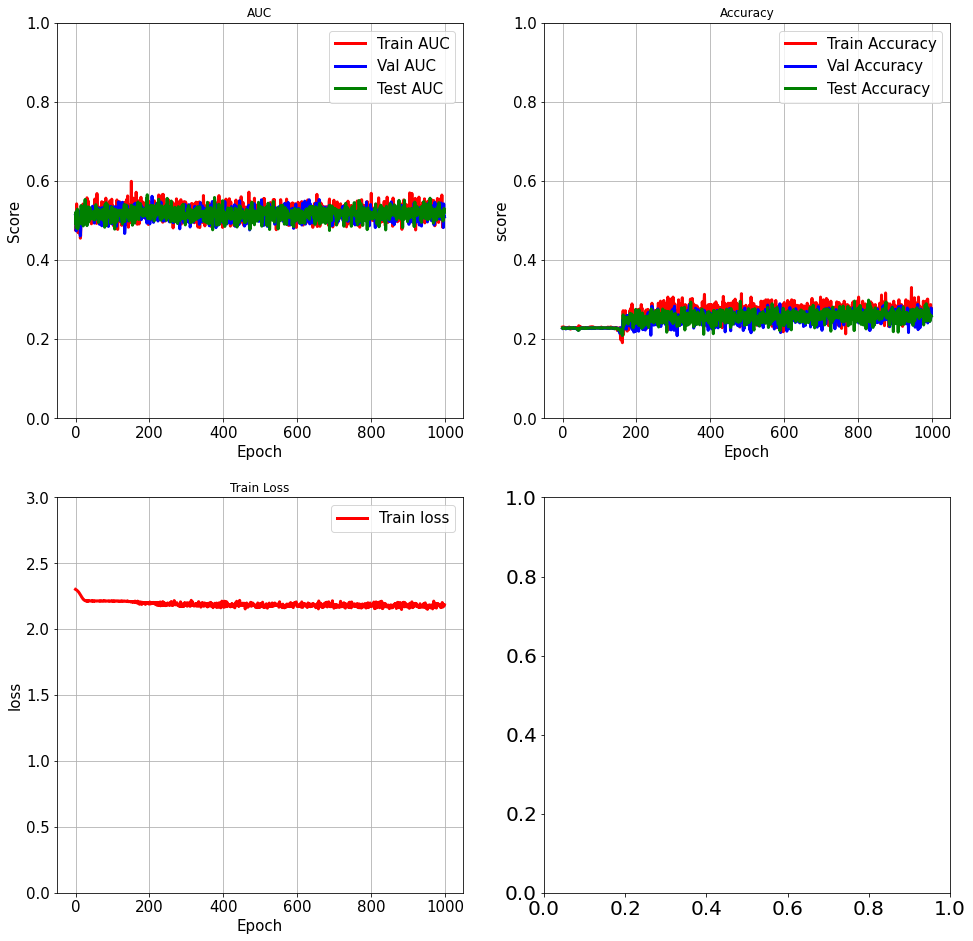

In [24]:
# visualize

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize = (16,16))

# AUC
axes[0][0].plot(scores['train_auc'], c = 'r', linestyle = 'solid', linewidth = 3)
axes[0][0].plot(scores['val_auc'], c = 'b', linestyle = 'solid', linewidth = 3)
axes[0][0].plot(scores['test_auc'], c = 'g', linestyle = 'solid', linewidth = 3)

axes[0][0].set_ylim(0,1)

axes[0][0].set_title("AUC")
axes[0][0].set_xlabel('Epoch', fontsize = 15)
axes[0][0].set_ylabel('Score', fontsize = 15)

axes[0][0].tick_params(labelsize = 15)
axes[0][0].grid()

axes[0][0].legend(['Train AUC', 'Val AUC', 'Test AUC'], fontsize = 15)


# Accuracy
axes[0][1].plot(scores['train_accuracy'], c = 'r', linestyle = 'solid', linewidth = 3)
axes[0][1].plot(scores['val_accuracy'], c = 'b', linestyle = 'solid', linewidth = 3)
axes[0][1].plot(scores['test_accuracy'], c = 'g', linestyle = 'solid', linewidth = 3)

axes[0][1].set_ylim(0,1)

axes[0][1].set_title("Accuracy")
axes[0][1].set_xlabel('Epoch', fontsize = 15)
axes[0][1].set_ylabel('score', fontsize = 15)

axes[0][1].tick_params(labelsize = 15)
axes[0][1].grid()

axes[0][1].legend(['Train Accuracy', 'Val Accuracy', 'Test Accuracy'], fontsize = 15)


# office 31 loss
axes[1][0].plot(losses, c = 'r', linestyle = 'solid', linewidth = 3)

axes[1][0].set_ylim(0,3)

axes[1][0].set_title("Train Loss")
axes[1][0].set_xlabel('Epoch', fontsize = 15)
axes[1][0].set_ylabel('loss', fontsize = 15)

axes[1][0].tick_params(labelsize = 15)
axes[1][0].grid()

axes[1][0].legend(['Train loss'], fontsize = 15)


# plot
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')

plt.show()

